## 8. Convolutional Network model

<li> Build a Convolutional Network model. </li> <li> Train a model and fine tune its parameters for a one time-series from each cluster. </li> <li> Using found parameters, compute the forecast for a different time-series from the same cluster. </li>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import itertools

/Users/anastasiagolubkova/anaconda3/envs/exts-ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anastasiagolubkova/anaconda3/envs/exts-ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anastasiagolubkova/anaconda3/envs/exts-ml/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Use

In [2]:
df = pd.read_pickle('demand_data_for_modelling')
df.head(5)

,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h
0,1,2005-01-01 00:00:00,3304.0,0.0,0.330996,NaN,NaN
1,1,2005-01-01 01:00:00,3178.0,1.0,0.318373,NaN,NaN
2,1,2005-01-01 02:00:00,2981.0,2.0,0.298638,NaN,NaN
3,1,2005-01-01 03:00:00,2944.0,3.0,0.294931,NaN,NaN
4,1,2005-01-01 04:00:00,2934.0,4.0,0.293929,NaN,NaN


In [3]:
temperature = pd.read_pickle('temperature_for_modelling')
temperature.head(5)

,full_date,hourly_mean,normalized_temp
0,2005-01-01 00:00:00,44.535714,0.390571
1,2005-01-01 01:00:00,44.428571,0.389273
2,2005-01-01 02:00:00,43.535714,0.378460
3,2005-01-01 03:00:00,43.750000,0.381055
4,2005-01-01 04:00:00,43.321429,0.375865


In [4]:
humidity = pd.read_pickle('humidity_for_modelling')
humidity.head(5)

,full_date,hourly_mean,normalized_humidity
0,2005-01-01 00:00:00,87.535714,0.879677
1,2005-01-01 01:00:00,86.678571,0.869473
2,2005-01-01 02:00:00,86.964286,0.872874
3,2005-01-01 03:00:00,87.214286,0.875850
4,2005-01-01 04:00:00,87.357143,0.877551


Functions for modelling
--

Split the data into train, validation, and test sets:

In [5]:
def train_val_test_split(df, test_fraction, cols):
    train_fraction = 1-test_fraction
    val_fraction = train_fraction + test_fraction/2
    dates = df.groupby(df.date.dt.date).count().date 
    split_train = (int)(len(dates)*train_fraction)
    split_val = (int)(len(dates)*val_fraction)
    end_train_date = pd.to_datetime(dates.index[split_train])
    end_val_date = pd.to_datetime(dates.index[split_val])
    
    X_tr = df[df.date < end_train_date][cols].values
    y_tr = df[df.date < end_train_date]['normalized_demand'].values
                        
    X_val = df[(df.date >= end_train_date) & (df.date < end_val_date)][cols].values
    y_val = df[(df.date >= end_train_date) & (df.date < end_val_date)]['normalized_demand'].values
    
    X_te = df[df.date >= end_val_date][cols].values
    y_te = df[df.date >= end_val_date]['normalized_demand'].values
    
    print('Train set')
    print('---------')
    print('Features: {} Target: {}\n'.format(X_tr.shape,y_tr.shape))
    
    print('Validation set')
    print('---------')
    print('Features: {} Target: {}\n'.format(X_val.shape,y_val.shape))

    print('Test set')
    print('--------')    
    print('Features: {} Target: {}'.format(X_te.shape,y_te.shape))
    
    return (X_tr,X_val,X_te,y_tr,y_val,y_te)

Build samples for a supervised model:

In [6]:
def split_into_samples(X_features, y_target, event_length_features, event_length_target):
    
    # Function to split a time-series into samples: 
    # example [X1,X2,X3] features -> [y4,y5,y6] target
    
    X = []
    y = []
    
    for i in np.arange(len(X_features)):
        X_end_ind = i + event_length_features
        y_end_ind = X_end_ind + event_length_target-1
        
        if (y_end_ind <= len(X_features)):
            features = X_features[i:X_end_ind,:]
            target = y_target[X_end_ind-1:y_end_ind]
        
        X.append(features)
        y.append(target)

    print('Features samples: ', np.array(X).shape)   
    print('Target samples: ', np.array(y).shape)
        
    return np.array(X), np.array(y)

Build a Convolutional Neural Network model:

In [32]:
def conv_net_model(conv_config,pool_config,dense_config,epochs,batch_size,X_tr_samples,X_val_samples,y_tr_samples,y_val_samples):
    
    # Function to build and train a Convolutional Neural Network model with 1 convolutional and 1 max pool layer
    # conv_config is a tuple of lists with parameters for a convolutional layer, filters and kernel_size
    # pool_config is a list with a pool_size for a max pool layer
    # dense_config is a list with number of neurons in a dense layer
    
    # Define a network
    filters = conv_config[0]
    kernel_size = conv_config[1]
    pool_size = pool_config
    units = dense_config
    
    model = keras.Sequential()
    model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same',
                              activation='relu', input_shape=(X_tr_samples.shape[1],X_tr_samples.shape[2]))) 
    model.add(keras.layers.MaxPool1D(pool_size=pool_size))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=units, activation='relu'))
    model.add(keras.layers.Dense(y_tr_samples.shape[1]))
    print('Network configuration')
    model.summary()
    
    model.compile(optimizer=keras.optimizers.Adam(), loss='mse')
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    # Train a network
    history = model.fit(
    X_tr_samples, 
    y_tr_samples, 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1,
    shuffle=True,
    validation_data = (X_val_samples, y_val_samples), 
    callbacks=[early_stopping]
    )
    
    # Plot the results
    plt.plot(history.history['val_loss'][0:], label='validation')
    plt.plot(history.history['loss'][0:], label='training') 
    plt.legend()
    plt.show()
    
    return model

Compute MAE:

In [8]:
def MAE(y,y_pred):    
    return(np.mean(np.abs(y-y_pred)))

Plot the results:

In [9]:
def plot_predictions(X_tr,X_val,X_te,y_tr,y_val,y_te,y_pred_tr,y_pred_val,y_pred_te):
    
    font = {'fontname':'Arial', 'size':'14'}
    font_title = {'fontname':'Arial', 'size':'16'}

    plt.figure(figsize=(9,6))

    # True values
    plt.plot(X_tr[:,0],y_tr,label='train set',color='black')
    plt.plot(X_val[:,0],y_val,label='validation set',color='orange') 
    plt.plot(X_te[:,0],y_te,label='test set',color='grey')    

    # Predictions
    plt.plot(X_tr[:,0],y_pred_tr[:,0],label='predictions train',color='blue')
    plt.plot(X_val[:,0],y_pred_val[:,0],label='predictions validation',color='green')
    plt.plot(X_te[:,0],y_pred_te[:,0],label='predictions test',color='red')     

    plt.xlabel('Date',**font)
    plt.ylabel('Electricity demand',**font)

    plt.legend()
    plt.show()

Save the results:

In [10]:
def save_result(meter_id,X_tr,X_val,X_te,y_pred_tr,y_pred_val,y_pred_te):
    
    df1 = pd.DataFrame({"meter_id": [meter_id]*X_tr.shape[0], "date": X_tr[:,0], \
                        "type": ['training']*X_tr.shape[0], "pred_value": y_pred_tr})
    
    df2 = pd.DataFrame({"meter_id": [meter_id]*X_val.shape[0], "date": X_val[:,0], \
                        "type": ['validation']*X_val.shape[0], "pred_value": y_pred_val})
    
    df3 = pd.DataFrame({"meter_id": [meter_id]*X_te.shape[0], "date": X_te[:,0], \
                        "type": ['test']*X_te.shape[0], "pred_value": y_pred_te})
    
    result = pd.concat([df1,df2,df3], ignore_index=True)
    return result

__Cluster 1__

Train a Convolutional Neural Network model for a meter 422 from the cluster 1.

In [11]:
meter_422 = df[df['meter_id']==422]
temperature_422 = temperature[temperature.full_date.isin(meter_422.date)]
humidity_422 = humidity[humidity.full_date.isin(meter_422.date)]
meter_422 = meter_422[meter_422.date.isin(temperature_422.full_date)]
meter_422 = meter_422[meter_422.date.isin(humidity_422.full_date)]
meter_422 = meter_422.reset_index()
meter_422['normalized_temp'] = temperature_422.normalized_temp
meter_422['normalized_humid'] = humidity_422.normalized_humidity
meter_422.head(5)

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,8347632,422,2005-01-01 00:00:00,12258.0,0.0,0.440665,NaN,NaN,0.390571,0.879677
1,8347633,422,2005-01-01 01:00:00,8016.0,1.0,0.240268,NaN,NaN,0.389273,0.869473
2,8347634,422,2005-01-01 02:00:00,7813.0,2.0,0.230678,NaN,NaN,0.378460,0.872874
3,8347635,422,2005-01-01 03:00:00,7527.0,3.0,0.217167,NaN,NaN,0.381055,0.875850
4,8347636,422,2005-01-01 04:00:00,7529.0,4.0,0.217262,NaN,NaN,0.375865,0.877551


In [12]:
meter_422.dropna(inplace=True)

Split the data into training, validation, and test sets:

In [13]:
X_tr_422,X_val_422,X_te_422,y_tr_422,y_val_422,y_te_422 = \
train_val_test_split(meter_422, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (49050, 4) Target: (49050,)

Validation set
---------
Features: (6119, 4) Target: (6119,)

Test set
--------
Features: (6144, 4) Target: (6144,)


Define the samples for training, validation, and test. Modelled event length is 24 hours:

In [14]:
X_tr_samples_422, y_tr_samples_422 = split_into_samples(X_tr_422[:,1:],y_tr_422,24,24)

Features samples:  (49050, 24, 3)
Target samples:  (49050, 24)


In [15]:
X_val_samples_422, y_val_samples_422 = split_into_samples(X_val_422[:,1:],y_val_422,24,24)

Features samples:  (6119, 24, 3)
Target samples:  (6119, 24)


In [16]:
X_te_samples_422, y_te_samples_422 = split_into_samples(X_te_422[:,1:],y_te_422,24,24)

Features samples:  (6144, 24, 3)
Target samples:  (6144, 24)


Build a Convolutional Neural Network with one convolutional layer and one pooling layer; train the model for each combination of parameters and save the performance on the validation set:

Total number of iterations for meter 422:  8
Tuning convolutional neural network for meter 422
-----------------
CONFIGURATION SET ([3, 2], 2, 5)
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 3)             0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 185       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                144       
Total params: 350
Trainable params: 350
Non-trainable params: 0
________________________

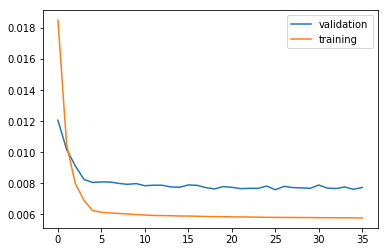

6144/6144 [==============================] - 0s 68us/step
Tuning convolutional neural network for meter 422
-----------------
CONFIGURATION SET ([3, 2], 2, 10)
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 3)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                370       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                264       
Total params: 655
Trainable params: 655
Non-trainable params: 0
__________

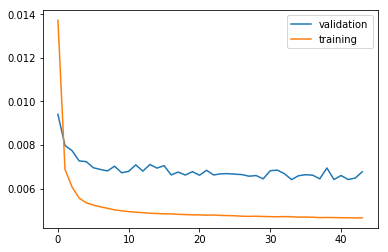

6144/6144 [==============================] - 0s 65us/step
Tuning convolutional neural network for meter 422
-----------------
CONFIGURATION SET ([3, 2], 3, 5)
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 3)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 125       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                144       
Total params: 290
Trainable params: 290
Non-trainable params: 0
___________

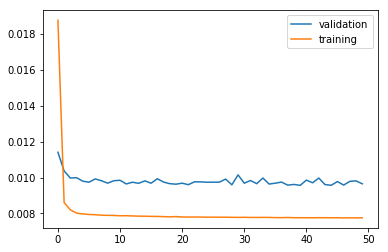

6144/6144 [==============================] - 0s 77us/step
Tuning convolutional neural network for meter 422
-----------------
CONFIGURATION SET ([3, 2], 3, 10)
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 3)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                250       
_________________________________________________________________
dense_7 (Dense)              (None, 24)                264       
Total params: 535
Trainable params: 535
Non-trainable params: 0
__________

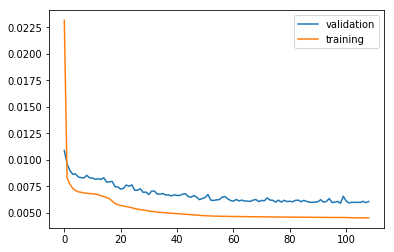

6144/6144 [==============================] - 0s 65us/step
Tuning convolutional neural network for meter 422
-----------------
CONFIGURATION SET ([2, 2], 2, 5)
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 2)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 125       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                144       
Total params: 283
Trainable params: 283
Non-trainable params: 0
___________

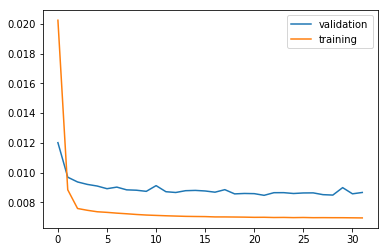

6144/6144 [==============================] - 0s 70us/step
Tuning convolutional neural network for meter 422
-----------------
CONFIGURATION SET ([2, 2], 2, 10)
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 12, 2)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                250       
_________________________________________________________________
dense_11 (Dense)             (None, 24)                264       
Total params: 528
Trainable params: 528
Non-trainable params: 0
__________

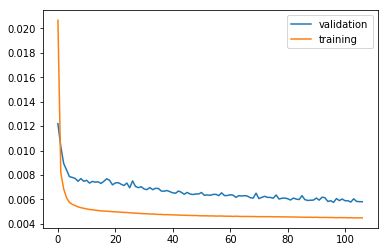

6144/6144 [==============================] - 0s 68us/step
Tuning convolutional neural network for meter 422
-----------------
CONFIGURATION SET ([2, 2], 3, 5)
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 8, 2)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 85        
_________________________________________________________________
dense_13 (Dense)             (None, 24)                144       
Total params: 243
Trainable params: 243
Non-trainable params: 0
___________

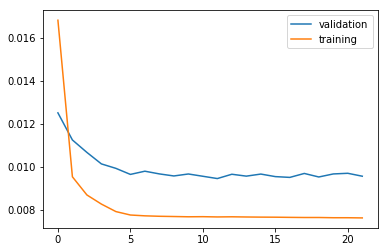

6144/6144 [==============================] - 0s 79us/step
Tuning convolutional neural network for meter 422
-----------------
CONFIGURATION SET ([2, 2], 3, 10)
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 8, 2)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_15 (Dense)             (None, 24)                264       
Total params: 448
Trainable params: 448
Non-trainable params: 0
__________

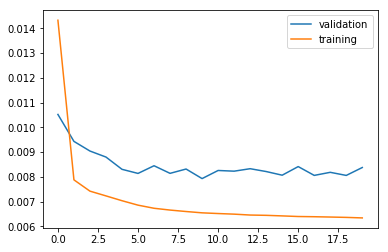

6144/6144 [==============================] - 1s 83us/step


In [33]:
# Pass parameters
conv = [3,2],[2,2] # Convolutional layer
pool = [2,3] # Max pool layer
units = [5,10] # Dense layer

# Define the combinations of parameters for search
grid = list(itertools.product(conv, pool, units))
print('Total number of parameter combinations for meter 422: ', len(grid))

search_result_422 = []
epochs = 2000
batch_size = None
count = 0

for item in grid:
    count += 1
    print('Tuning convolutional neural network for meter 422')
    print('-----------------')
    print('CONFIGURATION SET ' + str(item) + '; Iteration ' + str(count))
    print('-----------------')
    
    conv_config = item[0]
    pool_config = item[1]
    dense_config = item[2]
    
    model_422 = \
    conv_net_model(conv_config,pool_config,dense_config,epochs,batch_size,X_tr_samples_422,X_val_samples_422,y_tr_samples_422,y_val_samples_422)
    
    # Compute the prediction for this model
    y_pred = \
    model_422.predict(X_te_samples_422, verbose=1)
    
    # Save prediction errors to the dataframe
    result = {'Config': str(item), 'MAE_te': (MAE(y_te_samples_422[:,0], y_pred[:,0]))}
    search_result_422.append(result)

search_result_422 = pd.DataFrame(search_result_422)

In [34]:
search_result_422.sort_values(by = 'MAE_te', ascending=True)

,Config,MAE_te
3,"([3, 2], 3, 10)",0.045601
1,"([3, 2], 2, 10)",0.046951
2,"([3, 2], 3, 5)",0.050032
5,"([2, 2], 2, 10)",0.050618
4,"([2, 2], 2, 5)",0.051897
0,"([3, 2], 2, 5)",0.052794
7,"([2, 2], 3, 10)",0.053930
6,"([2, 2], 3, 5)",0.061451


Using the configuration set with the lowest MAE for the test set, train a network and compute the forecast for meter 481:

In [35]:
meter_481 = df[df['meter_id']==481]
temperature_481 = temperature[temperature.full_date.isin(meter_481.date)].reset_index()
humidity_481 = humidity[humidity.full_date.isin(meter_481.date)].reset_index()
meter_481 = meter_481[meter_481.date.isin(temperature_481.full_date)]
meter_481 = meter_481[meter_481.date.isin(humidity_481.full_date)]
meter_481 = meter_481.reset_index()
meter_481['normalized_temp'] = temperature_481.normalized_temp
meter_481['normalized_humid'] = humidity_481.normalized_humidity
meter_481.head()

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,9432360,481,2009-04-16 00:00:00,0.0,0.0,0.000000,NaN,NaN,0.424740,0.740221
1,9432361,481,2009-04-16 01:00:00,0.0,1.0,0.000000,NaN,NaN,0.410900,0.750850
2,9432362,481,2009-04-16 02:00:00,8.0,2.0,0.000563,NaN,NaN,0.397491,0.763605
3,9432363,481,2009-04-16 03:00:00,7.0,3.0,0.000492,NaN,NaN,0.387543,0.764881
4,9432364,481,2009-04-16 04:00:00,8.0,4.0,0.000563,NaN,NaN,0.380623,0.773384


In [36]:
meter_481.dropna(inplace=True)

Split the data into training, validation, and test sets:

In [37]:
X_tr_481,X_val_481,X_te_481,y_tr_481,y_val_481,y_te_481 = \
train_val_test_split(meter_481, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (18982, 4) Target: (18982,)

Validation set
---------
Features: (2376, 4) Target: (2376,)

Test set
--------
Features: (2376, 4) Target: (2376,)


Define data samples:

In [38]:
X_tr_samples_481, y_tr_samples_481 = split_into_samples(X_tr_481[:,1:],y_tr_481,24,24)

Features samples:  (18982, 24, 3)
Target samples:  (18982, 24)


In [39]:
X_val_samples_481, y_val_samples_481 = split_into_samples(X_val_481[:,1:],y_val_481,24,24)

Features samples:  (2376, 24, 3)
Target samples:  (2376, 24)


In [40]:
X_te_samples_481, y_te_samples_481 = split_into_samples(X_te_481[:,1:],y_te_481,24,24)

Features samples:  (2376, 24, 3)
Target samples:  (2376, 24)


Train the network:

Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 8, 3)              0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                250       
_________________________________________________________________
dense_17 (Dense)             (None, 24)                264       
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________
Train on 18982 samples, validate on 2376 samples
Epoch 1/2000
18982/18982 [==============================] - 5s 246us/step

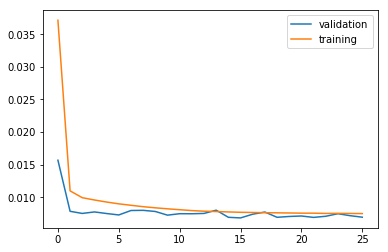

In [41]:
model_481 = \
conv_net_model([3,2],3,10,2000,None,X_tr_samples_481,X_val_samples_481,y_tr_samples_481,y_val_samples_481)

Compute the forecast:

In [42]:
# Compute predictions on train/validation/test sets

y_pred_tr_481 = \
    model_481.predict(X_tr_samples_481,verbose=1)

y_pred_val_481 = \
    model_481.predict(X_val_samples_481,verbose=1)

y_pred_te_481 = \
    model_481.predict(X_te_samples_481,verbose=1)

# Compute a MAE on train/validation/test sets
mae_tr_481 = MAE(y_tr_samples_481[:,0], y_pred_tr_481[:,0])
mae_val_481 = MAE(y_val_samples_481[:,0], y_pred_val_481[:,0])
mae_te_481 = MAE(y_te_samples_481[:,0], y_pred_te_481[:,0])


print('---------')
print('Meter 481')
print('---------')

print('Train set MAE')
print('MAE computed on the train set: ', np.round(mae_tr_481,2))
print('---------')

print('Validation set MAE')
print('MAE computed on the train set: ', np.round(mae_val_481,2))
print('---------')

print('Test set MAE')  
print('MAE computed on the test set: ', np.round(mae_te_481, 2))
print('--------')  

2376/2376 [==============================] - 0s 56us/step
---------
Meter 481
---------
Train set MAE
MAE computed on the train set:  0.05
---------
Validation set MAE
MAE computed on the train set:  0.05
---------
Test set MAE
MAE computed on the test set:  0.05
--------


Plot the results:

/Users/anastasiagolubkova/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


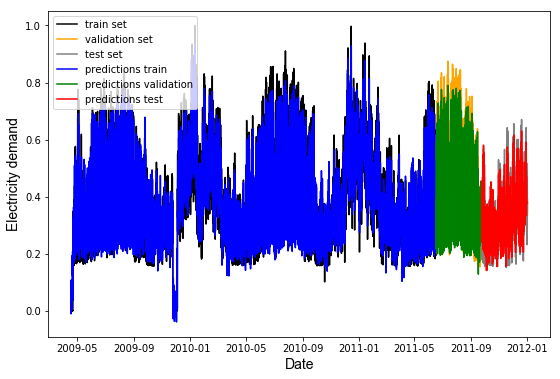

In [43]:
plot_predictions(X_tr_481,X_val_481,X_te_481,y_tr_481,y_val_481,y_te_481,y_pred_tr_481,y_pred_val_481,y_pred_te_481)

Save the results:

In [44]:
pred_481 = save_result(481,X_tr_481,X_val_481,X_te_481,y_pred_tr_481[:,0],y_pred_val_481[:,0],y_pred_te_481[:,0])

In [45]:
pred_481.to_pickle('ConvNet_meter481')

__Cluster 2__

Tune a Convolutional Neural Network model for a meter 60 from the cluster 2.

In [46]:
meter_60 = df[df['meter_id']==60]
temperature_60 = temperature[temperature.full_date.isin(meter_60.date)]
humidity_60 = humidity[humidity.full_date.isin(meter_60.date)]
meter_60 = meter_60[meter_60.date.isin(temperature_60.full_date)]
meter_60 = meter_60[meter_60.date.isin(humidity_60.full_date)]
meter_60 = meter_60.reset_index()
meter_60['normalized_temp'] = temperature_60.normalized_temp
meter_60['normalized_humid'] = humidity_60.normalized_humidity
meter_60.head(5)

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,1587432,60,2005-01-01 00:00:00,4379.0,0.0,0.078669,NaN,NaN,0.390571,0.879677
1,1587433,60,2005-01-01 01:00:00,5598.0,1.0,0.155943,NaN,NaN,0.389273,0.869473
2,1587434,60,2005-01-01 02:00:00,5502.0,2.0,0.149857,NaN,NaN,0.378460,0.872874
3,1587435,60,2005-01-01 03:00:00,5442.0,3.0,0.146054,NaN,NaN,0.381055,0.875850
4,1587436,60,2005-01-01 04:00:00,5562.0,4.0,0.153661,NaN,NaN,0.375865,0.877551


In [47]:
meter_60.dropna(inplace=True)

In [48]:
X_tr_60,X_val_60,X_te_60,y_tr_60,y_val_60,y_te_60 = \
train_val_test_split(meter_60, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (49050, 4) Target: (49050,)

Validation set
---------
Features: (6119, 4) Target: (6119,)

Test set
--------
Features: (6144, 4) Target: (6144,)


In [49]:
X_tr_samples_60, y_tr_samples_60 = split_into_samples(X_tr_60[:,1:],y_tr_60,24,24)

Features samples:  (49050, 24, 3)
Target samples:  (49050, 24)


In [50]:
X_val_samples_60, y_val_samples_60 = split_into_samples(X_val_60[:,1:],y_val_60,24,24)

Features samples:  (6119, 24, 3)
Target samples:  (6119, 24)


In [51]:
X_te_samples_60, y_te_samples_60 = split_into_samples(X_te_60[:,1:],y_te_60,24,24)

Features samples:  (6144, 24, 3)
Target samples:  (6144, 24)


Total number of parameter combinations for meter 60:  8
Tuning convolutional neural network for meter 60
-----------------
CONFIGURATION SET ([3, 2], 2, 5); Iteration 1
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 12, 3)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 36)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 185       
_________________________________________________________________
dense_19 (Dense)             (None, 24)                144       
Total params: 350
Trainable params: 350
Non-trainable params: 0
_

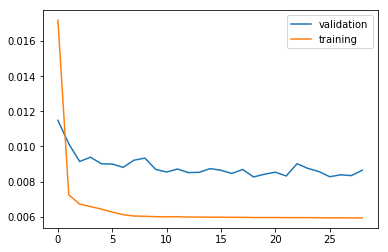

6144/6144 [==============================] - 1s 108us/step
Tuning convolutional neural network for meter 60
-----------------
CONFIGURATION SET ([3, 2], 2, 10); Iteration 2
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 12, 3)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 36)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                370       
_________________________________________________________________
dense_21 (Dense)             (None, 24)                264       
Total params: 655
Trainable params: 655
Non-trainable params:

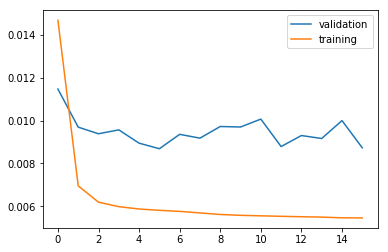

6144/6144 [==============================] - 1s 125us/step
Tuning convolutional neural network for meter 60
-----------------
CONFIGURATION SET ([3, 2], 3, 5); Iteration 3
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 8, 3)              0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 125       
_________________________________________________________________
dense_23 (Dense)             (None, 24)                144       
Total params: 290
Trainable params: 290
Non-trainable params: 

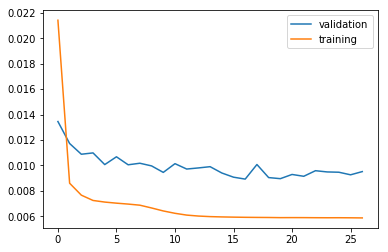

6144/6144 [==============================] - 1s 110us/step
Tuning convolutional neural network for meter 60
-----------------
CONFIGURATION SET ([3, 2], 3, 10); Iteration 4
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 8, 3)              0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                250       
_________________________________________________________________
dense_25 (Dense)             (None, 24)                264       
Total params: 535
Trainable params: 535
Non-trainable params:

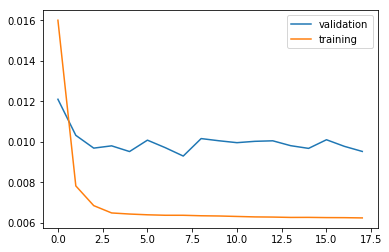

6144/6144 [==============================] - 1s 112us/step
Tuning convolutional neural network for meter 60
-----------------
CONFIGURATION SET ([2, 2], 2, 5); Iteration 5
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 12, 2)             0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 125       
_________________________________________________________________
dense_27 (Dense)             (None, 24)                144       
Total params: 283
Trainable params: 283
Non-trainable params: 

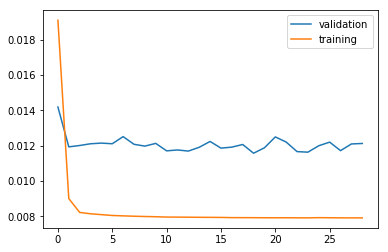

6144/6144 [==============================] - 1s 112us/step
Tuning convolutional neural network for meter 60
-----------------
CONFIGURATION SET ([2, 2], 2, 10); Iteration 6
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 12, 2)             0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                250       
_________________________________________________________________
dense_29 (Dense)             (None, 24)                264       
Total params: 528
Trainable params: 528
Non-trainable params:

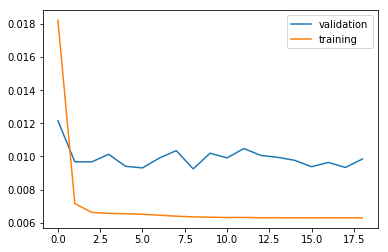

6144/6144 [==============================] - 1s 115us/step
Tuning convolutional neural network for meter 60
-----------------
CONFIGURATION SET ([2, 2], 3, 5); Iteration 7
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 8, 2)              0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 85        
_________________________________________________________________
dense_31 (Dense)             (None, 24)                144       
Total params: 243
Trainable params: 243
Non-trainable params: 

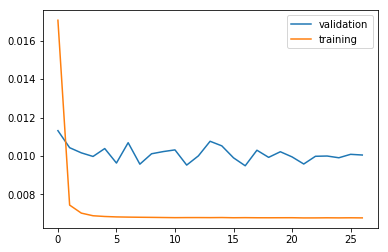

6144/6144 [==============================] - 1s 120us/step
Tuning convolutional neural network for meter 60
-----------------
CONFIGURATION SET ([2, 2], 3, 10); Iteration 8
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 8, 2)              0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_33 (Dense)             (None, 24)                264       
Total params: 448
Trainable params: 448
Non-trainable params:

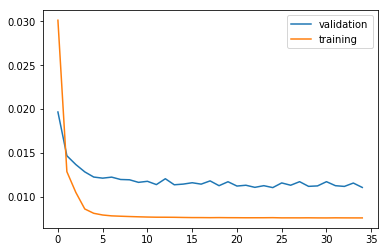

6144/6144 [==============================] - 1s 146us/step


In [52]:
# Pass parameters
conv = [3,2],[2,2] # Convolutional layer
pool = [2,3] # Max pool layer
units = [5,10] # Dense layer

# Define the combinations of parameters for search
grid = list(itertools.product(conv, pool, units))
print('Total number of parameter combinations for meter 60: ', len(grid))

search_result_60 = []
epochs = 2000
batch_size = None
count = 0

for item in grid:
    count += 1
    print('Tuning convolutional neural network for meter 60')
    print('-----------------')
    print('CONFIGURATION SET ' + str(item) + '; Iteration ' + str(count))
    print('-----------------')
    
    conv_config = item[0]
    pool_config = item[1]
    dense_config = item[2]
    
    model_60 = \
    conv_net_model(conv_config,pool_config,dense_config,epochs,batch_size,X_tr_samples_60,X_val_samples_60,y_tr_samples_60,y_val_samples_60)
    
    # Compute the prediction for this model
    y_pred = \
    model_60.predict(X_te_samples_60, verbose=1)
    
    # Save prediction errors to the dataframe
    result = {'Config': str(item), 'MAE_te': (MAE(y_te_samples_60[:,0], y_pred[:,0]))}
    search_result_60.append(result)

search_result_60 = pd.DataFrame(search_result_60)

In [53]:
search_result_422.sort_values(by = 'MAE_te', ascending=True)

,Config,MAE_te
3,"([3, 2], 3, 10)",0.045601
1,"([3, 2], 2, 10)",0.046951
2,"([3, 2], 3, 5)",0.050032
5,"([2, 2], 2, 10)",0.050618
4,"([2, 2], 2, 5)",0.051897
0,"([3, 2], 2, 5)",0.052794
7,"([2, 2], 3, 10)",0.053930
6,"([2, 2], 3, 5)",0.061451


Using a configuration which corresponds to the lowest MAE on the test data, train the network and compute the forecast for meter 10:

In [54]:
meter_10 = df[df['meter_id']==10]
temperature_10 = temperature[temperature.full_date.isin(meter_10.date)].reset_index()
humidity_10 = humidity[humidity.full_date.isin(meter_10.date)].reset_index()
meter_10 = meter_10[meter_10.date.isin(temperature_10.full_date)]
meter_10 = meter_10[meter_10.date.isin(humidity_10.full_date)]
meter_10 = meter_10.reset_index()
meter_10['normalized_temp'] = temperature_10.normalized_temp
meter_10['normalized_humid'] = humidity_10.normalized_humidity
meter_10.head(5)

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,483240,10,2005-01-01 00:00:00,2027.0,0.0,0.117804,NaN,NaN,0.390571,0.879677
1,483241,10,2005-01-01 01:00:00,3072.0,1.0,0.229211,NaN,NaN,0.389273,0.869473
2,483242,10,2005-01-01 02:00:00,2870.0,2.0,0.207676,NaN,NaN,0.378460,0.872874
3,483243,10,2005-01-01 03:00:00,2851.0,3.0,0.205650,NaN,NaN,0.381055,0.875850
4,483244,10,2005-01-01 04:00:00,2900.0,4.0,0.210874,NaN,NaN,0.375865,0.877551


In [55]:
meter_10.dropna(inplace=True)

In [56]:
X_tr_10,X_val_10,X_te_10,y_tr_10,y_val_10,y_te_10 = \
train_val_test_split(meter_10, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (49050, 4) Target: (49050,)

Validation set
---------
Features: (6119, 4) Target: (6119,)

Test set
--------
Features: (6144, 4) Target: (6144,)


In [57]:
X_tr_samples_10, y_tr_samples_10 = split_into_samples(X_tr_10[:,1:],y_tr_10,24,24)

Features samples:  (49050, 24, 3)
Target samples:  (49050, 24)


In [58]:
X_val_samples_10, y_val_samples_10 = split_into_samples(X_val_10[:,1:],y_val_10,24,24)

Features samples:  (6119, 24, 3)
Target samples:  (6119, 24)


In [59]:
X_te_samples_10, y_te_samples_10 = split_into_samples(X_te_10[:,1:],y_te_10,24,24)

Features samples:  (6144, 24, 3)
Target samples:  (6144, 24)


Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 8, 3)              0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 10)                250       
_________________________________________________________________
dense_35 (Dense)             (None, 24)                264       
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________
Train on 49050 samples, validate on 6119 samples
Epoch 1/2000
49050/49050 [==============================] - 15s 314us/ste

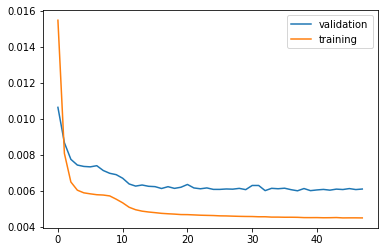

In [60]:
model_10 = \
conv_net_model([3,2],3,10,2000,None,X_tr_samples_10,X_val_samples_10,y_tr_samples_10,y_val_samples_10)

In [61]:
# Compute predictions on train/validation/test sets

y_pred_tr_10 = \
    model_10.predict(X_tr_samples_10,verbose=1)

y_pred_val_10 = \
    model_10.predict(X_val_samples_10,verbose=1)

y_pred_te_10 = \
    model_10.predict(X_te_samples_10,verbose=1)

# Compute a MAE on train/validation/test sets
mae_tr_10 = MAE(y_tr_samples_10[:,0], y_pred_tr_10[:,0])
mae_val_10 = MAE(y_val_samples_10[:,0], y_pred_val_10[:,0])
mae_te_10 = MAE(y_te_samples_10[:,0], y_pred_te_10[:,0])


print('---------')
print('Meter 10')
print('---------')

print('Train set MAE')
print('MAE computed on the train set: ', np.round(mae_tr_10,2))
print('---------')

print('Validation set MAE')
print('MAE computed on the train set: ', np.round(mae_val_10,2))
print('---------')

print('Test set MAE')  
print('MAE computed on the test set: ', np.round(mae_te_10, 2))
print('--------')  

6144/6144 [==============================] - 0s 59us/step
---------
Meter 10
---------
Train set MAE
MAE computed on the train set:  0.04
---------
Validation set MAE
MAE computed on the train set:  0.05
---------
Test set MAE
MAE computed on the test set:  0.04
--------


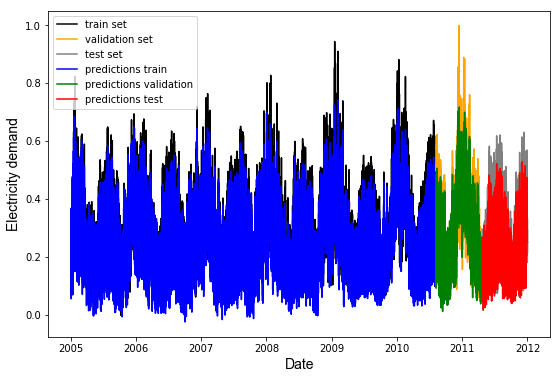

In [62]:
plot_predictions(X_tr_10,X_val_10,X_te_10,y_tr_10,y_val_10,y_te_10,y_pred_tr_10,y_pred_val_10,y_pred_te_10)

In [64]:
pred_10 = save_result(10,X_tr_10,X_val_10,X_te_10,y_pred_tr_10[:,0],y_pred_val_10[:,0],y_pred_te_10[:,0])

In [65]:
pred_10.to_pickle('ConvNet_meter10')

__Cluster 3__

Tune a Convolutional Neural Network model for a meter 412 from the cluster 3.

In [66]:
meter_412 = df[df['meter_id']==412]
temperature_412 = temperature[temperature.full_date.isin(meter_412.date)]
humidity_412 = humidity[humidity.full_date.isin(meter_412.date)]
meter_412 = meter_412[meter_412.date.isin(temperature_412.full_date)]
meter_412 = meter_412[meter_412.date.isin(humidity_412.full_date)]
meter_412 = meter_412.reset_index()
meter_412['normalized_temp'] = temperature_412.normalized_temp
meter_412['normalized_humid'] = humidity_412.normalized_humidity
meter_412.head()

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,7979568,412,2005-01-01 00:00:00,714.5,0.0,0.324478,NaN,NaN,0.390571,0.879677
1,7979569,412,2005-01-01 01:00:00,8.0,1.0,0.003633,NaN,NaN,0.389273,0.869473
2,7979570,412,2005-01-01 02:00:00,8.0,2.0,0.003633,NaN,NaN,0.378460,0.872874
3,7979571,412,2005-01-01 03:00:00,8.0,3.0,0.003633,NaN,NaN,0.381055,0.875850
4,7979572,412,2005-01-01 04:00:00,8.0,4.0,0.003633,NaN,NaN,0.375865,0.877551


In [67]:
meter_412.dropna(inplace=True)

In [68]:
X_tr_412,X_val_412,X_te_412,y_tr_412,y_val_412,y_te_412 = \
train_val_test_split(meter_412, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (49050, 4) Target: (49050,)

Validation set
---------
Features: (6119, 4) Target: (6119,)

Test set
--------
Features: (6144, 4) Target: (6144,)


In [69]:
X_tr_samples_412, y_tr_samples_412 = split_into_samples(X_tr_412[:,1:],y_tr_412,24,24)

Features samples:  (49050, 24, 3)
Target samples:  (49050, 24)


In [70]:
X_val_samples_412, y_val_samples_412 = split_into_samples(X_val_412[:,1:],y_val_412,24,24)

Features samples:  (6119, 24, 3)
Target samples:  (6119, 24)


In [71]:
X_te_samples_412, y_te_samples_412 = split_into_samples(X_te_412[:,1:],y_te_412,24,24)

Features samples:  (6144, 24, 3)
Target samples:  (6144, 24)


Total number of parameter combinations for meter 412:  8
Tuning convolutional neural network for meter 412
-----------------
CONFIGURATION SET ([3, 2], 2, 5); Iteration 1
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 12, 3)             0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 36)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 185       
_________________________________________________________________
dense_37 (Dense)             (None, 24)                144       
Total params: 350
Trainable params: 350
Non-trainable params: 0

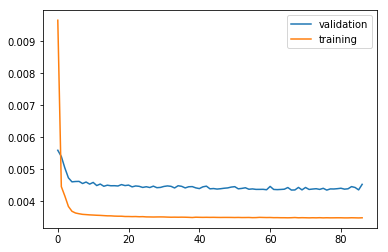

6144/6144 [==============================] - 1s 173us/step
Tuning convolutional neural network for meter 412
-----------------
CONFIGURATION SET ([3, 2], 2, 10); Iteration 2
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 12, 3)             0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 36)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                370       
_________________________________________________________________
dense_39 (Dense)             (None, 24)                264       
Total params: 655
Trainable params: 655
Non-trainable params

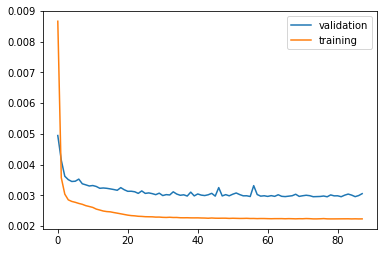

6144/6144 [==============================] - 1s 161us/step
Tuning convolutional neural network for meter 412
-----------------
CONFIGURATION SET ([3, 2], 3, 5); Iteration 3
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 8, 3)              0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 125       
_________________________________________________________________
dense_41 (Dense)             (None, 24)                144       
Total params: 290
Trainable params: 290
Non-trainable params:

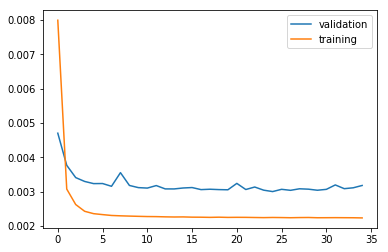

6144/6144 [==============================] - 1s 165us/step
Tuning convolutional neural network for meter 412
-----------------
CONFIGURATION SET ([3, 2], 3, 10); Iteration 4
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 24, 3)             21        
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 8, 3)              0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                250       
_________________________________________________________________
dense_43 (Dense)             (None, 24)                264       
Total params: 535
Trainable params: 535
Non-trainable params

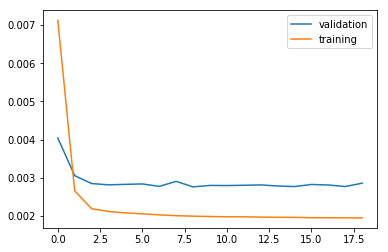

6144/6144 [==============================] - 1s 218us/step
Tuning convolutional neural network for meter 412
-----------------
CONFIGURATION SET ([2, 2], 2, 5); Iteration 5
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 12, 2)             0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 125       
_________________________________________________________________
dense_45 (Dense)             (None, 24)                144       
Total params: 283
Trainable params: 283
Non-trainable params:

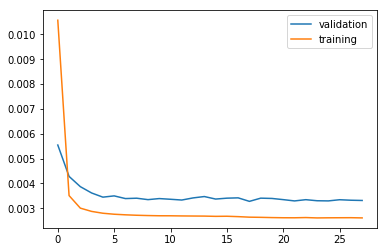

6144/6144 [==============================] - 1s 171us/step
Tuning convolutional neural network for meter 412
-----------------
CONFIGURATION SET ([2, 2], 2, 10); Iteration 6
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 12, 2)             0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)                250       
_________________________________________________________________
dense_47 (Dense)             (None, 24)                264       
Total params: 528
Trainable params: 528
Non-trainable params

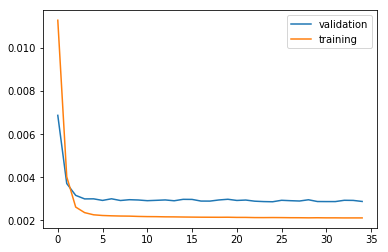

6144/6144 [==============================] - 1s 175us/step
Tuning convolutional neural network for meter 412
-----------------
CONFIGURATION SET ([2, 2], 3, 5); Iteration 7
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 8, 2)              0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 85        
_________________________________________________________________
dense_49 (Dense)             (None, 24)                144       
Total params: 243
Trainable params: 243
Non-trainable params:

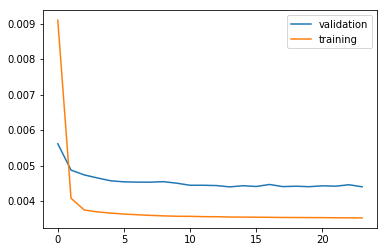

6144/6144 [==============================] - 1s 170us/step
Tuning convolutional neural network for meter 412
-----------------
CONFIGURATION SET ([2, 2], 3, 10); Iteration 8
-----------------
Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 8, 2)              0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_51 (Dense)             (None, 24)                264       
Total params: 448
Trainable params: 448
Non-trainable params

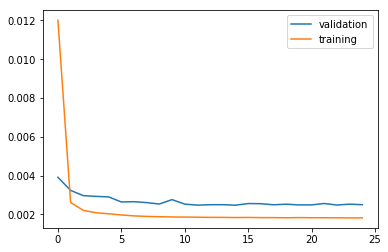

6144/6144 [==============================] - 1s 188us/step


In [72]:
# Pass parameters
conv = [3,2],[2,2] # Convolutional layer
pool = [2,3] # Max pool layer
units = [5,10] # Dense layer

# Define the combinations of parameters for search
grid = list(itertools.product(conv, pool, units))
print('Total number of parameter combinations for meter 412: ', len(grid))

search_result_412 = []
epochs = 2000
batch_size = None
count = 0

for item in grid:
    count += 1
    print('Tuning convolutional neural network for meter 412')
    print('-----------------')
    print('CONFIGURATION SET ' + str(item) + '; Iteration ' + str(count))
    print('-----------------')
    
    conv_config = item[0]
    pool_config = item[1]
    dense_config = item[2]
    
    model_412 = \
    conv_net_model(conv_config,pool_config,dense_config,epochs,batch_size,X_tr_samples_412,X_val_samples_412,y_tr_samples_412,y_val_samples_412)
    
    # Compute the prediction for this model
    y_pred = \
    model_412.predict(X_te_samples_412, verbose=1)
    
    # Save prediction errors to the dataframe
    result = {'Config': str(item), 'MAE_te': (MAE(y_te_samples_412[:,0], y_pred[:,0]))}
    search_result_412.append(result)

search_result_412 = pd.DataFrame(search_result_412)

In [73]:
search_result_412.sort_values(by = 'MAE_te', ascending=True)

,Config,MAE_te
7,"([2, 2], 3, 10)",0.020210
5,"([2, 2], 2, 10)",0.021169
1,"([3, 2], 2, 10)",0.021720
2,"([3, 2], 3, 5)",0.025178
4,"([2, 2], 2, 5)",0.025369
3,"([3, 2], 3, 10)",0.026270
6,"([2, 2], 3, 5)",0.027942
0,"([3, 2], 2, 5)",0.032726


Using a configuration which corresponds to the lowest MAE on the test data, train the network and compute the forecast for meter 453:

In [74]:
meter_453 = df[df['meter_id']==453]
temperature_453 = temperature[temperature.full_date.isin(meter_453.date)].reset_index()
humidity_453 = humidity[humidity.full_date.isin(meter_453.date)].reset_index()
meter_453 = meter_453[meter_453.date.isin(temperature_453.full_date)]
meter_453 = meter_453[meter_453.date.isin(humidity_453.full_date)]
meter_453 = meter_453.reset_index()
meter_453['normalized_temp'] = temperature_453.normalized_temp
meter_453['normalized_humid'] = humidity_453.normalized_humidity
meter_453.head(5)

,index,meter_id,date,demand,hours,normalized_demand,demand-24h,normalized_demand-24h,normalized_temp,normalized_humid
0,8980008,453,2005-06-01 00:00:00,1898.5,0.0,0.392983,NaN,NaN,0.608131,0.737245
1,8980009,453,2005-06-01 01:00:00,0.0,1.0,0.000000,NaN,NaN,0.602941,0.736395
2,8980010,453,2005-06-01 02:00:00,0.0,2.0,0.000000,NaN,NaN,0.595156,0.760204
3,8980011,453,2005-06-01 03:00:00,0.0,3.0,0.000000,NaN,NaN,0.586505,0.781037
4,8980012,453,2005-06-01 04:00:00,0.0,4.0,0.000000,NaN,NaN,0.581315,0.802721


In [75]:
meter_453.dropna(inplace=True)

In [76]:
X_tr_453,X_val_453,X_te_453,y_tr_453,y_val_453,y_te_453 = \
train_val_test_split(meter_453, 0.2, ['date','normalized_demand-24h','normalized_temp','normalized_humid'])

Train set
---------
Features: (46147, 4) Target: (46147,)

Validation set
---------
Features: (5759, 4) Target: (5759,)

Test set
--------
Features: (5784, 4) Target: (5784,)


In [77]:
X_tr_samples_453, y_tr_samples_453 = split_into_samples(X_tr_453[:,1:],y_tr_453,24,24)

Features samples:  (46147, 24, 3)
Target samples:  (46147, 24)


In [81]:
X_val_samples_453, y_val_samples_453 = split_into_samples(X_val_453[:,1:],y_val_453,24,24)

Features samples:  (5759, 24, 3)
Target samples:  (5759, 24)


In [82]:
X_te_samples_453, y_te_samples_453 = split_into_samples(X_te_453[:,1:],y_te_453,24,24)

Features samples:  (5784, 24, 3)
Target samples:  (5784, 24)


Network configuration
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 24, 2)             14        
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 8, 2)              0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_53 (Dense)             (None, 24)                264       
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________
Train on 46147 samples, validate on 5759 samples
Epoch 1/2000
46147/46147 [==============================] - 11s 233us/ste

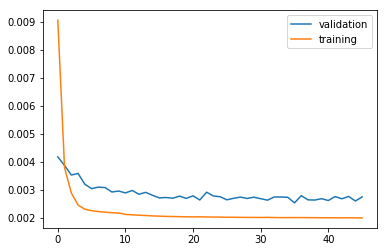

In [83]:
model_453 = \
conv_net_model([2,2],3,10,2000,None,X_tr_samples_453,X_val_samples_453,y_tr_samples_453,y_val_samples_453)

In [84]:
# Compute predictions on train/validation/test sets

y_pred_tr_453 = \
    model_453.predict(X_tr_samples_453,verbose=1)

y_pred_val_453 = \
    model_453.predict(X_val_samples_453,verbose=1)

y_pred_te_453 = \
    model_453.predict(X_te_samples_453,verbose=1)

# Compute a MAE on train/validation/test sets
mae_tr_453 = MAE(y_tr_samples_453[:,0], y_pred_tr_453[:,0])
mae_val_453 = MAE(y_val_samples_453[:,0], y_pred_val_453[:,0])
mae_te_453 = MAE(y_te_samples_453[:,0], y_pred_te_453[:,0])


print('---------')
print('Meter 453')
print('---------')

print('Train set MAE')
print('MAE computed on the train set: ', np.round(mae_tr_453,2))
print('---------')

print('Validation set MAE')
print('MAE computed on the train set: ', np.round(mae_val_453,2))
print('---------')

print('Test set MAE')  
print('MAE computed on the test set: ', np.round(mae_te_453, 2))
print('--------')  

5784/5784 [==============================] - 0s 81us/step
---------
Meter 453
---------
Train set MAE
MAE computed on the train set:  0.03
---------
Validation set MAE
MAE computed on the train set:  0.03
---------
Test set MAE
MAE computed on the test set:  0.07
--------


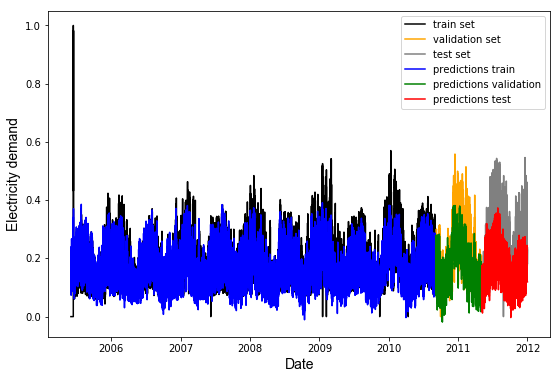

In [85]:
plot_predictions(X_tr_453,X_val_453,X_te_453,y_tr_453,y_val_453,y_te_453,y_pred_tr_453,y_pred_val_453,y_pred_te_453)

In [86]:
pred_453 = save_result(453,X_tr_453,X_val_453,X_te_453,y_pred_tr_453[:,0],y_pred_val_453[:,0],y_pred_te_453[:,0])

In [87]:
pred_453.to_pickle('ConvNet_meter453')